# HMM

In [61]:
from hmmlearn import hmm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Define a function to train and plot an HMM

In [62]:
def train_and_plot_single(
    visible_sequence_train,
    visible_sequence_test, 
    n_components : int = 2, 
    ) -> np.array:
    
    # create and train an HMM model
    model = hmm.GaussianHMM(n_components=n_components)
    model.fit(visible_sequence_train)

    # predict the most likely sequence of internal hidden state
    prob, hidden_sequence = model.decode(visible_sequence_test, algorithm='viterbi')

    # transform the numpy matrix into a 1-D list
    visible_sequence_test = [i[0] for i in visible_sequence_test]

    colors_map = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "gray", 9: "olive", 10: "cyan"}

    # map the hidden states to colors
    colors_sequence = [colors_map[i] for i in hidden_sequence]

    plt.subplots(figsize=(21, 9))
    # set the x axis label
    plt.xlabel('Samplings (10min intervals)')
    # set the y axis label
    plt.ylabel('Value')
    # set the title
    plt.title(f'HMM Model with {n_components} hidden states')

    plt.bar(
        x = [i for i in range(len(visible_sequence_test))],
        height = visible_sequence_test,
        color = colors_sequence
    )

    plt.show()

    return hidden_sequence, model


## Train and test split

In [63]:
# get the column "Appliance" and "light" from the dataset

df = pd.read_csv("energydata_complete.csv", usecols=["Appliances", "lights"])

# trasfrorm the Appliances column into a numpy matrix
x_app = df["Appliances"].to_numpy().reshape(-1, 1)
x_light = df["lights"].to_numpy().reshape(-1, 1)

# split the x arrays in weeks, there are 19 weeks in the dataset
x_app = np.array_split(x_app, len(x_app) / 1008)
x_light = np.array_split(x_light, len(x_light) / 1008)

# the test set will the 4 middle weeks
test_set_app = x_app[6:10]
test_set_light = x_light[6:10]

# the train set will be the first 7 weeks and the last 7 weeks
train_set_app = x_app[:6] + x_app[10:]
train_set_light = x_light[:6] + x_light[10:]

# merge the weeks in a single array
train_set_app = np.concatenate(train_set_app)
test_set_app = np.concatenate(test_set_app)
train_set_light = np.concatenate(train_set_light)
test_set_light = np.concatenate(test_set_light)


## Appliances dataset

### Example with two states

Since the values are sampled every 10 minutes, one day is represented by 144 points, one week by 1008 points and one month by 4320 points.
We are going to plot the results for a period of 1 month

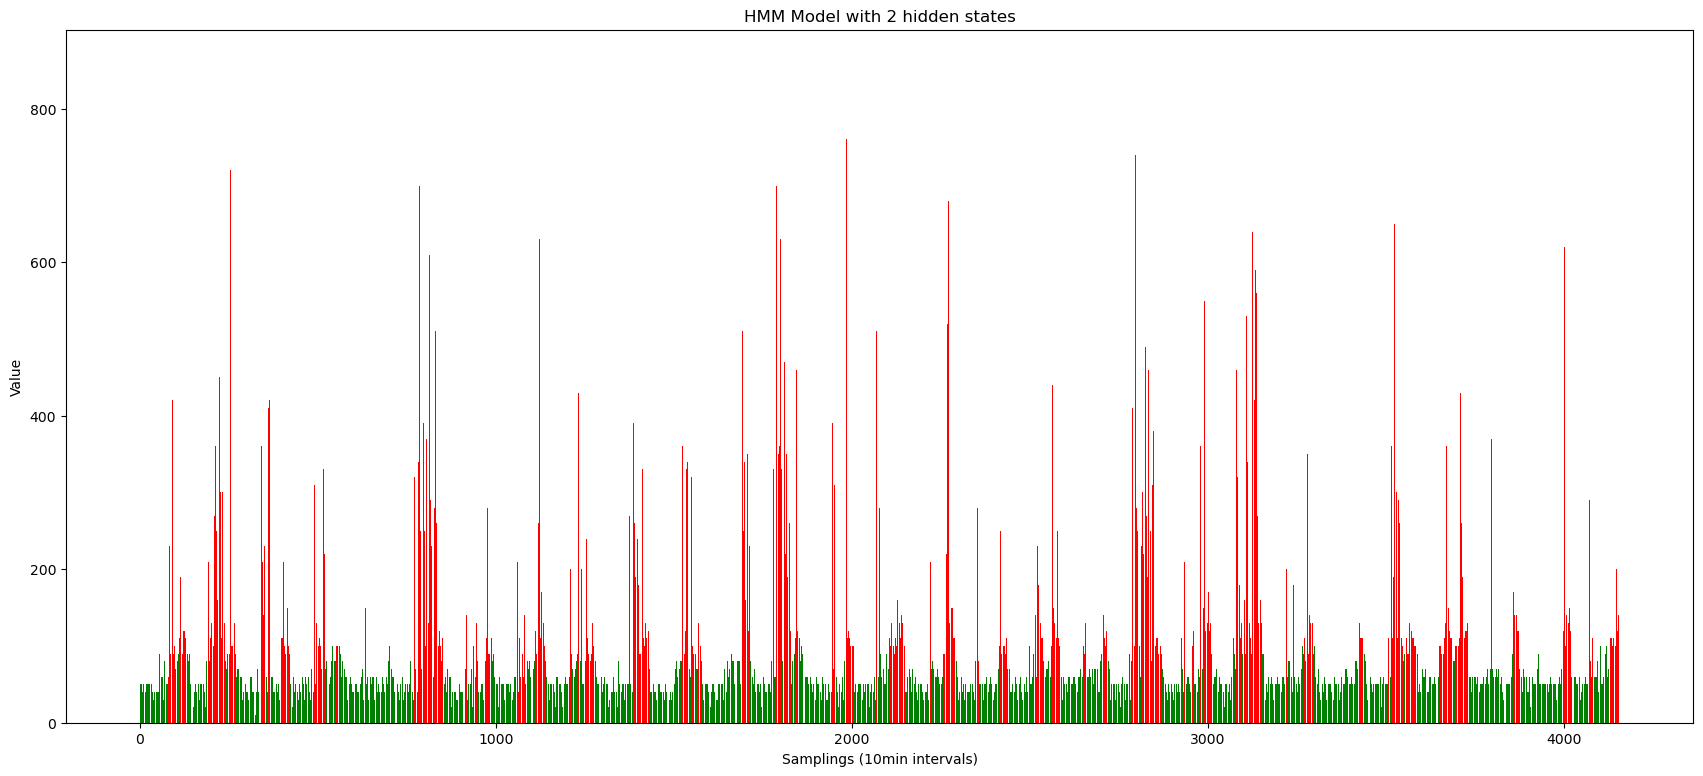

In [64]:
appliance_models = {}

hidden_sequence, appliance_models[2] = train_and_plot_single(
    visible_sequence_train=train_set_app, 
    visible_sequence_test=test_set_app,
    n_components=2
)

### Example with 3-5 states

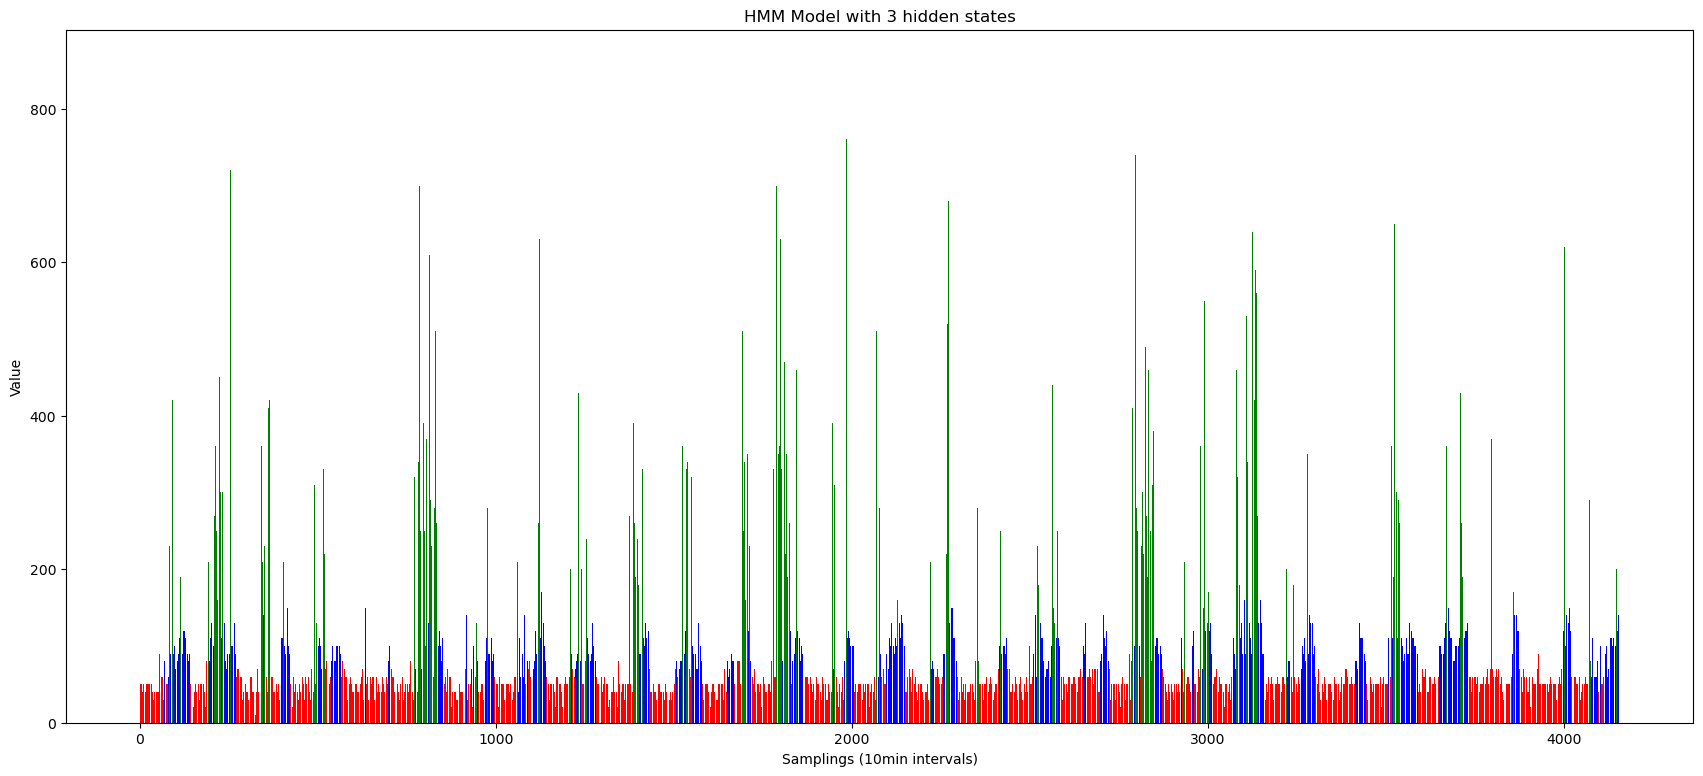

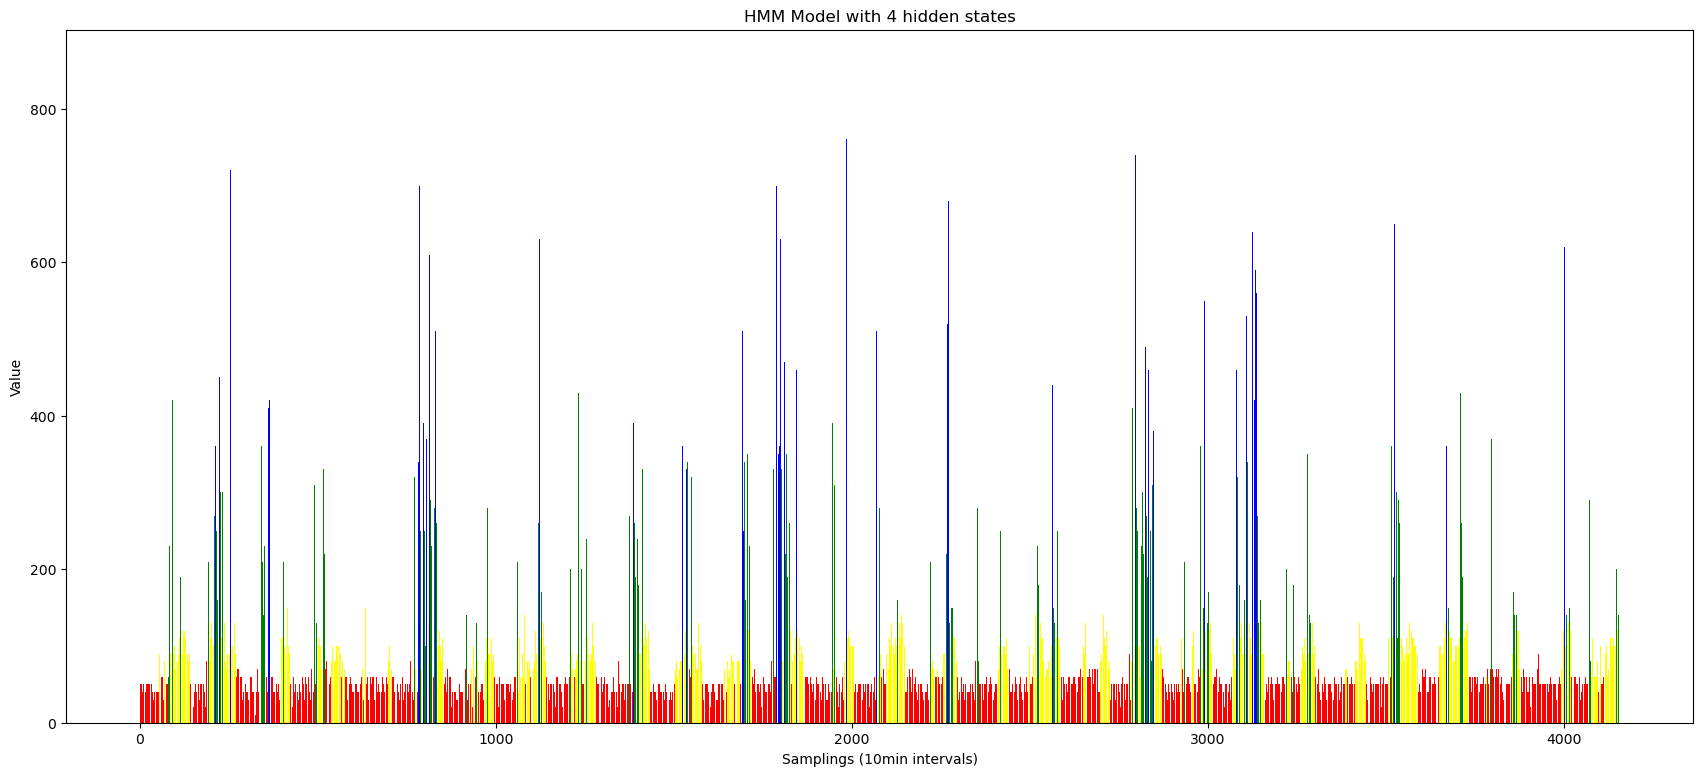

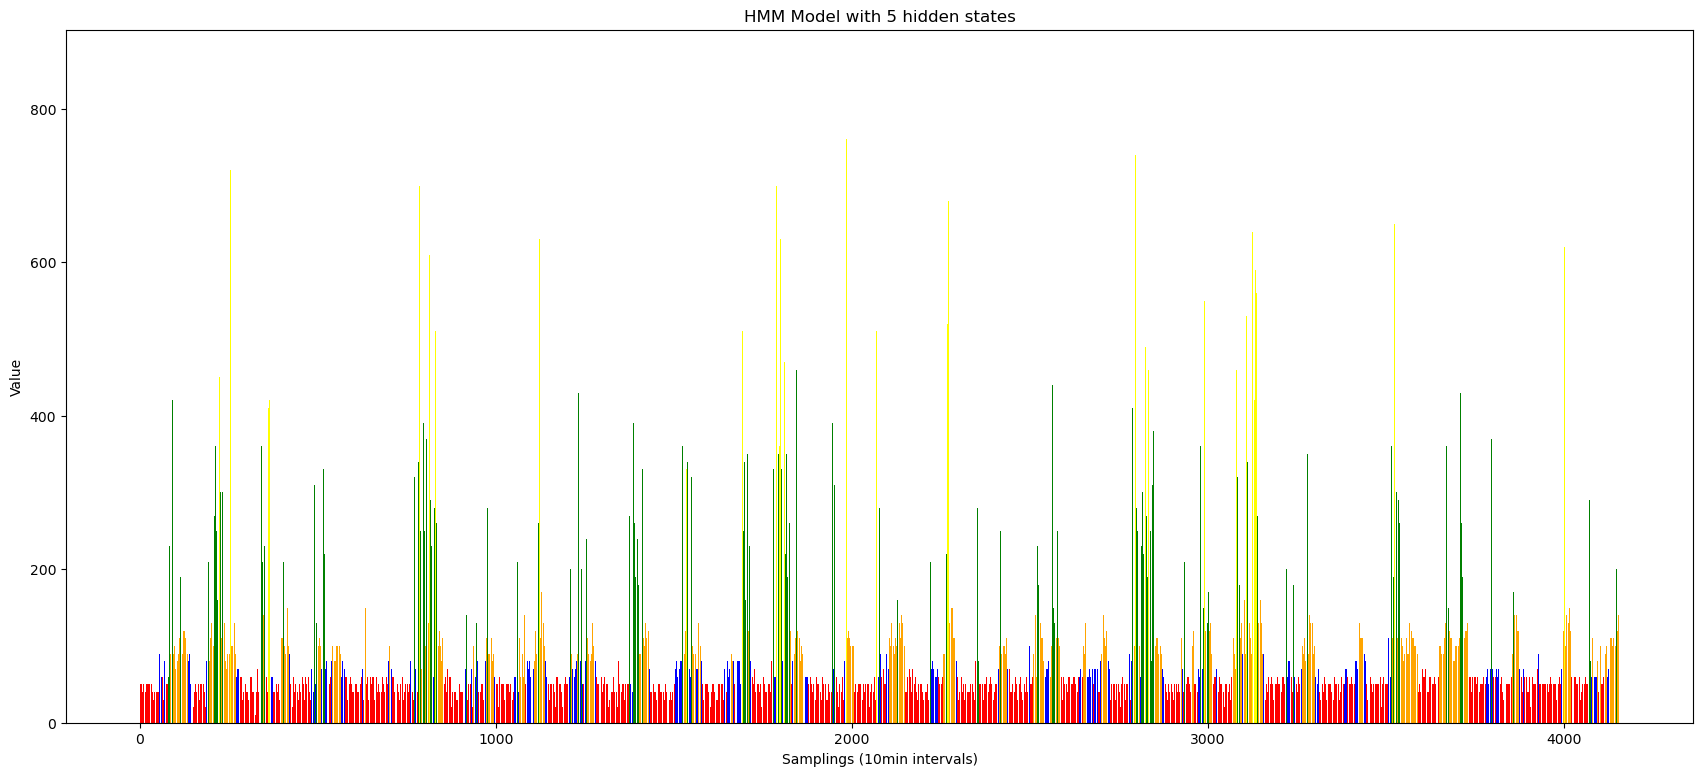

In [65]:
for i in range(3, 6):
    _, appliance_models[i] = train_and_plot_single(
    visible_sequence_train=train_set_app, 
    visible_sequence_test=test_set_app,
    n_components=i
)

In [66]:
for i in appliance_models.keys():
    print(f"Score for model with {i} hidden states: {appliance_models[i].score(test_set_app)}")

Score for model with 2 hidden states: -20816.066440789466
Score for model with 3 hidden states: -19421.60952561028
Score for model with 4 hidden states: -19279.158092300913
Score for model with 5 hidden states: -19077.34325168174


# Lights dataset

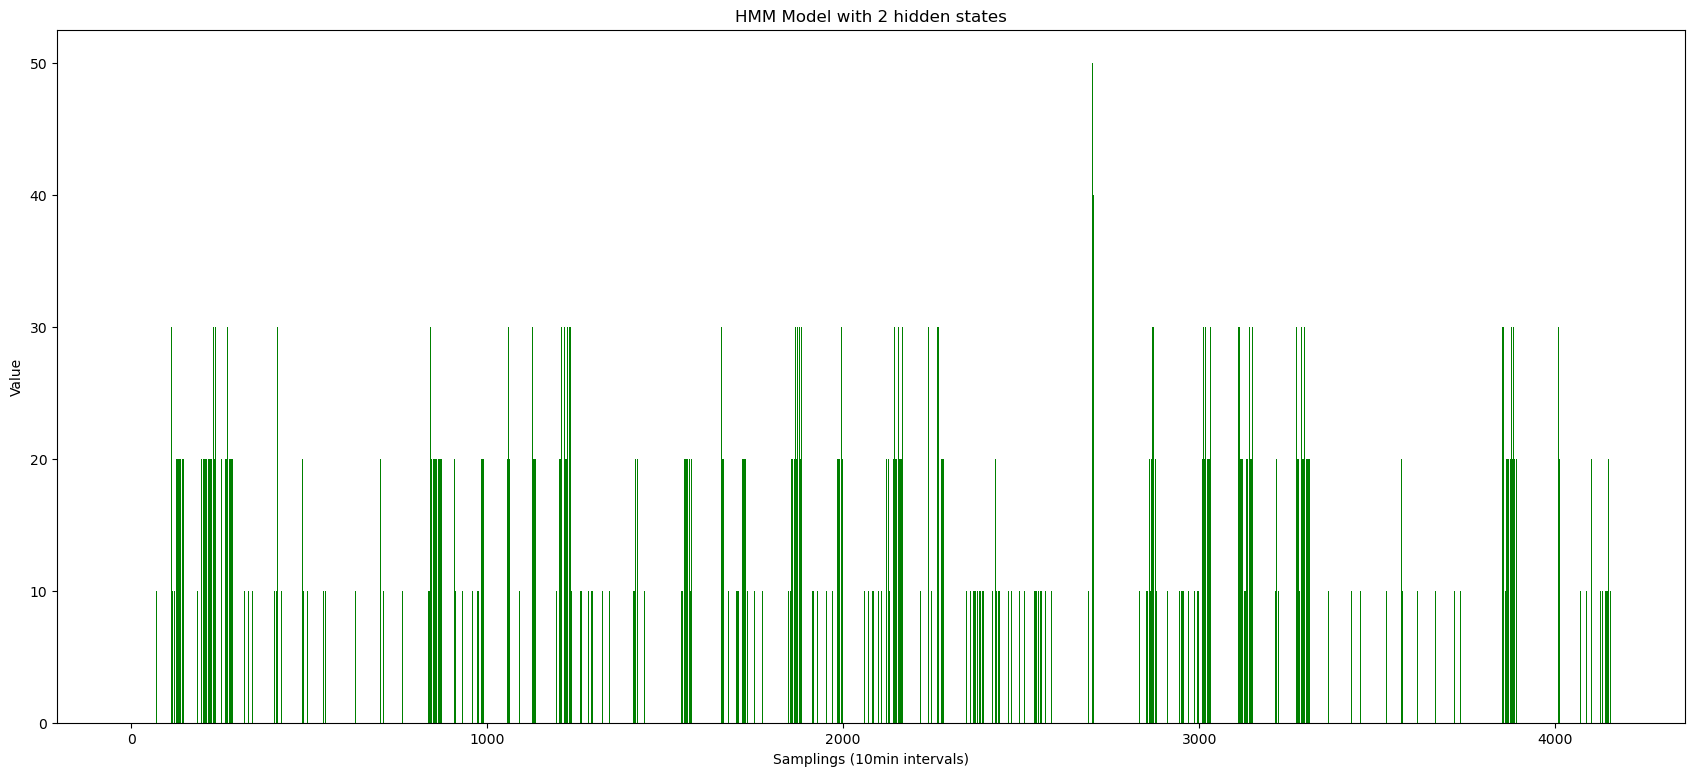

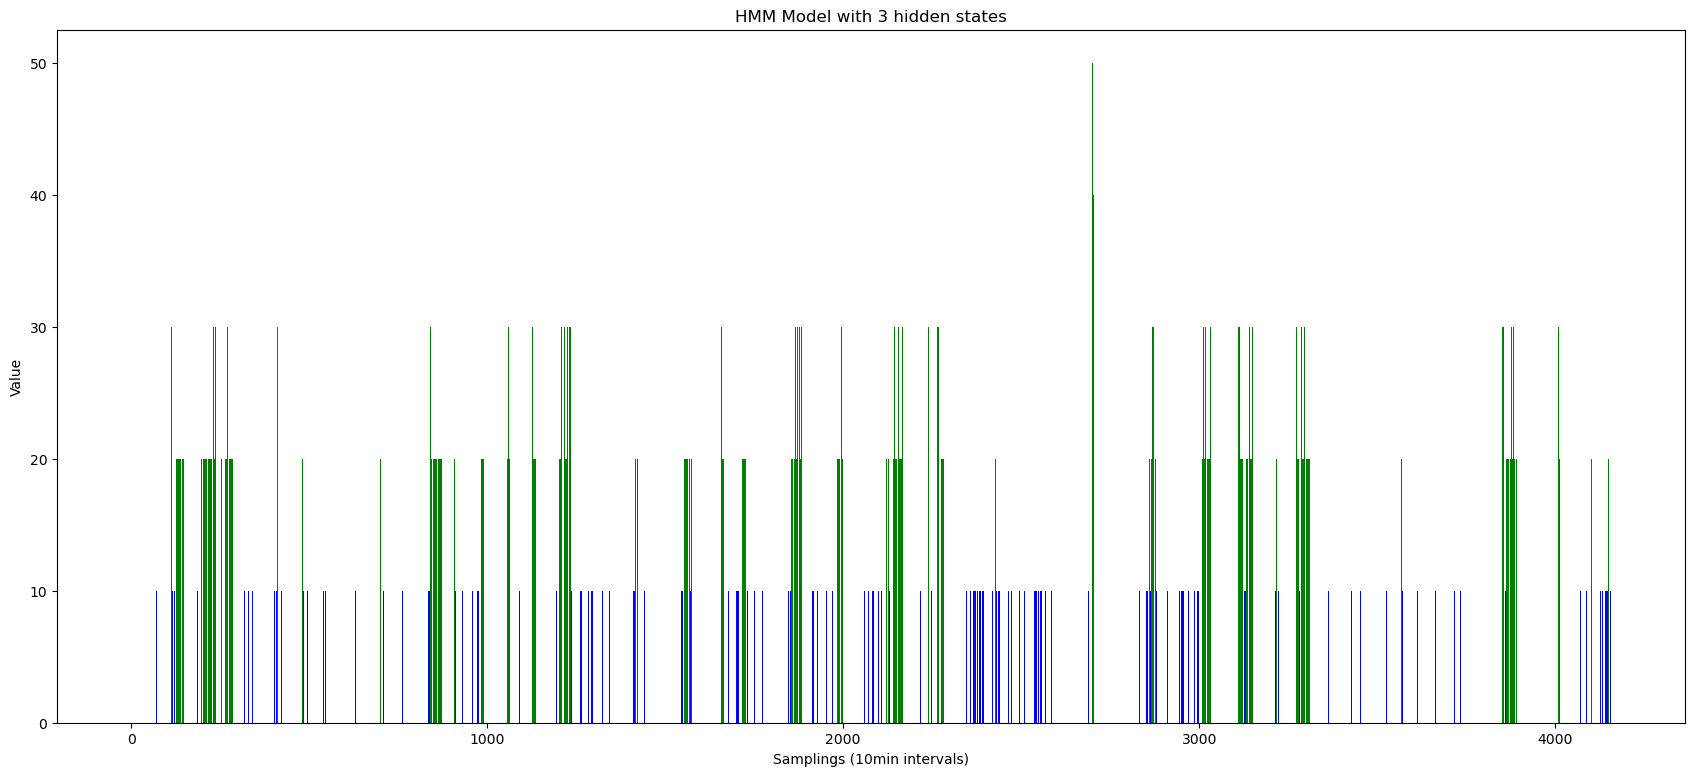

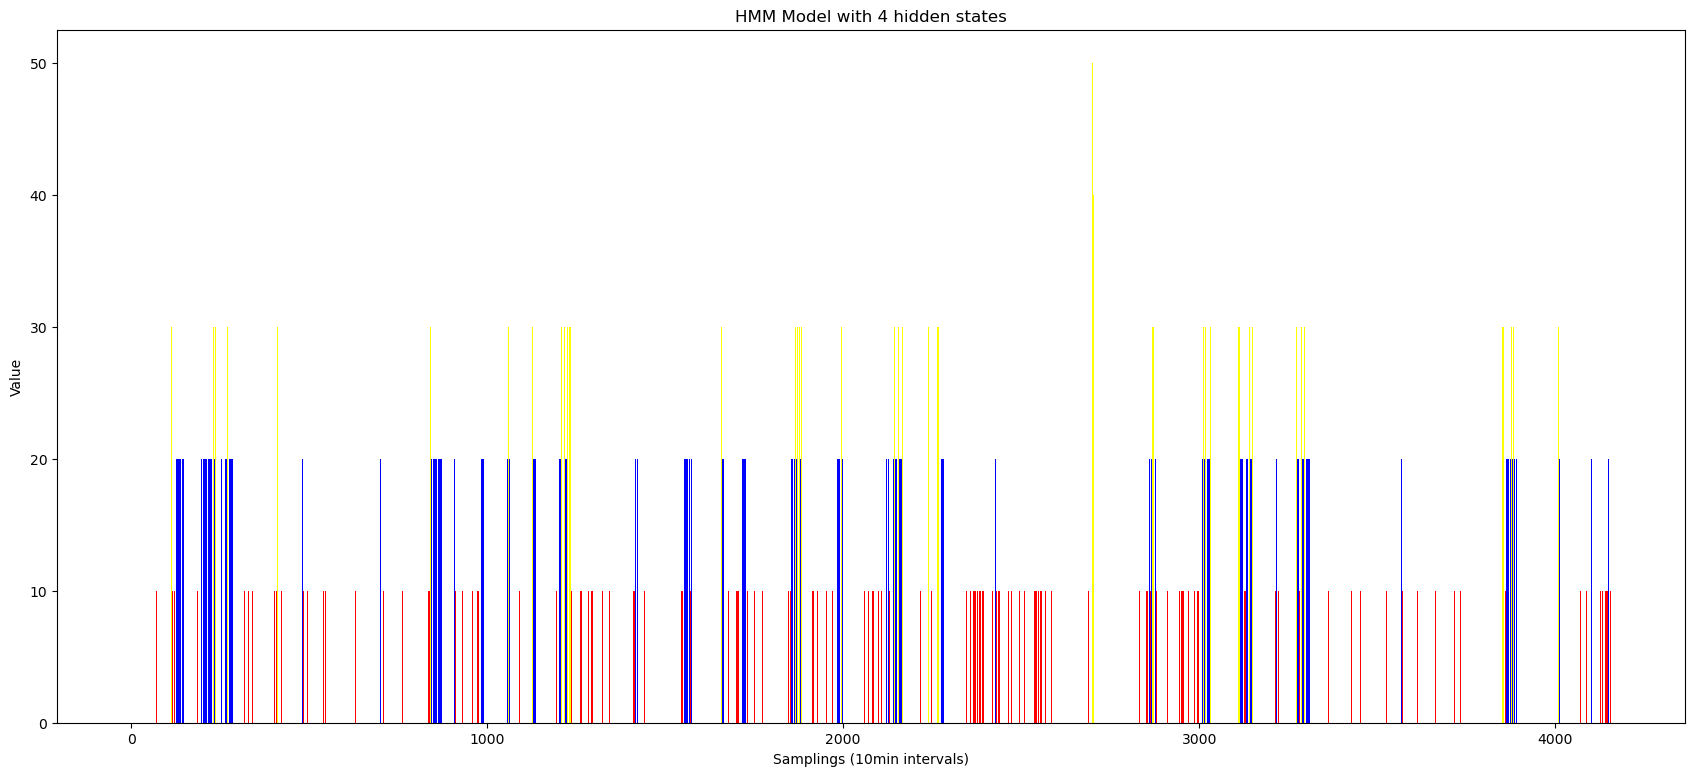

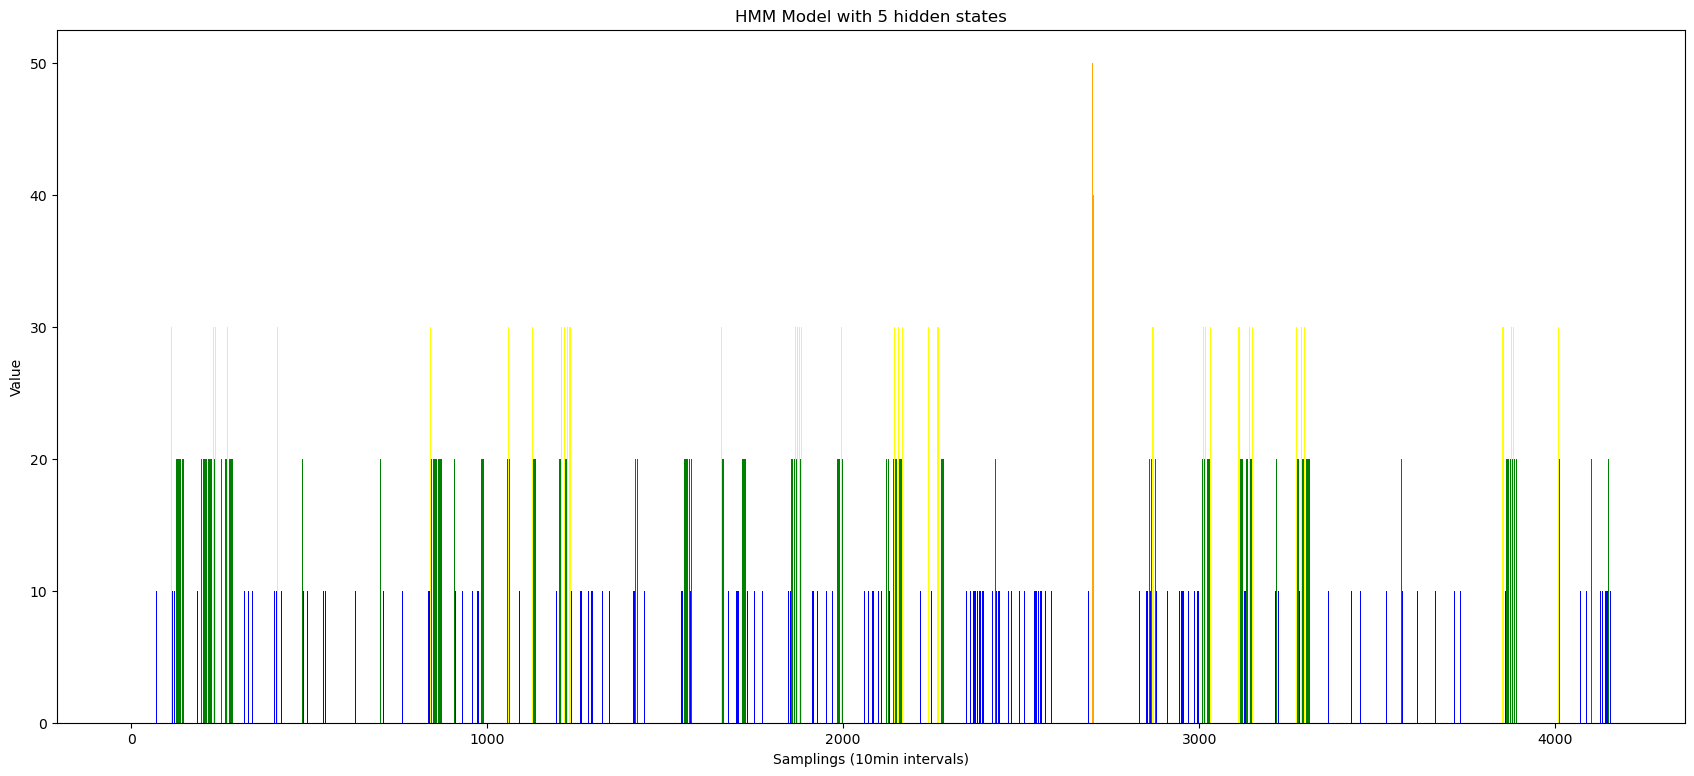

In [67]:
light_models = {}

for i in range(2, 6):
    _, light_models[i] = train_and_plot_single(
    visible_sequence_train=train_set_light, 
    visible_sequence_test=test_set_light,
    n_components=i
)

## Model performance

Since the "light" dataset is discrete and there are only 8 different values in the test set, we can try to fit a model with 8 hidden state and see if it is able to perfectly fit the data.

In [82]:
light_models[2].startprob_

array([0., 1.])

In [68]:
for i in light_models.keys():
    print(f"Score for model with {i} hidden states: {light_models[i].score(test_set_light)}")

Score for model with 2 hidden states: 13746.219031051907
Score for model with 3 hidden states: 17811.607810786903
Score for model with 4 hidden states: 20667.560764710946
Score for model with 5 hidden states: 21746.035606037265


# Double emission distribution

Let's join again the two features of the timeseries in a single matrix in order to train an HMM with two emission distributions.

In [72]:
# join the two features in a single matrix

train_set_mixed = np.concatenate((train_set_app, train_set_light), axis=1)
test_set_mixed = np.concatenate((test_set_app, test_set_light), axis=1)

test_set_mixed.shape

(4156, 2)

The following is a function that trains the HMM with two features and the plots two different barplot, one for each feature.

In [73]:
def train_and_plot_double(
    visible_sequence_train,
    visible_sequence_test, 
    n_components : int = 2, 
    ) -> np.array:
    
    # create and train an HMM model
    model = hmm.GaussianHMM(n_components=n_components)
    model.fit(visible_sequence_train)

    # predict the most likely sequence of internal hidden state
    prob, hidden_sequence = model.decode(visible_sequence_test, algorithm='viterbi')

    # transform the numpy matrix into a 1-D list
    visible_sequence_test_0 = [i[0] for i in visible_sequence_test]
    visible_sequence_test_1 = [i[1] for i in visible_sequence_test]

    colors_map = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "gray", 9: "olive", 10: "cyan"}

    # map the hidden states to colors
    colors_sequence = [colors_map[i] for i in hidden_sequence]

    plt.subplots(figsize=(21, 9))
    plt.xlabel('Samplings (10min intervals)')
    plt.ylabel('Value')
    plt.title(f'HMM Model with {n_components} hidden states. First feature.')
    plt.bar(
        x = [i for i in range(len(visible_sequence_test_0))],
        height = visible_sequence_test_0,
        color = colors_sequence
    )
    plt.show()
    
    plt.subplots(figsize=(21, 9))
    plt.xlabel('Samplings (10min intervals)')
    plt.ylabel('Value')
    plt.title(f'HMM Model with {n_components} hidden states. Second feature.')
    plt.bar(
        x = [i for i in range(len(visible_sequence_test_1))],
        height = visible_sequence_test_1,
        color = colors_sequence
    )
    plt.show()
 

    return hidden_sequence, model

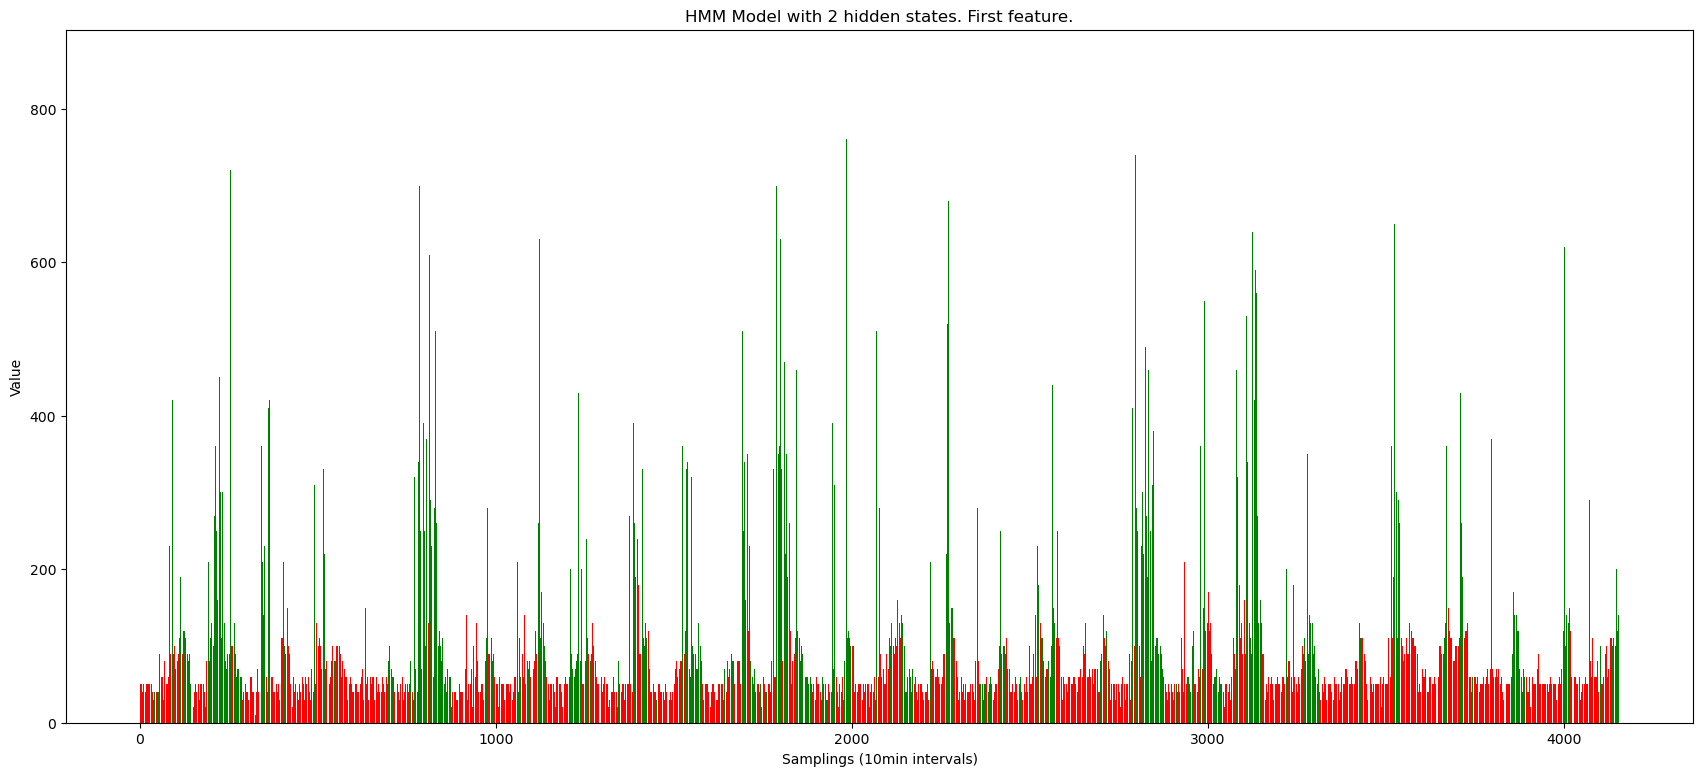

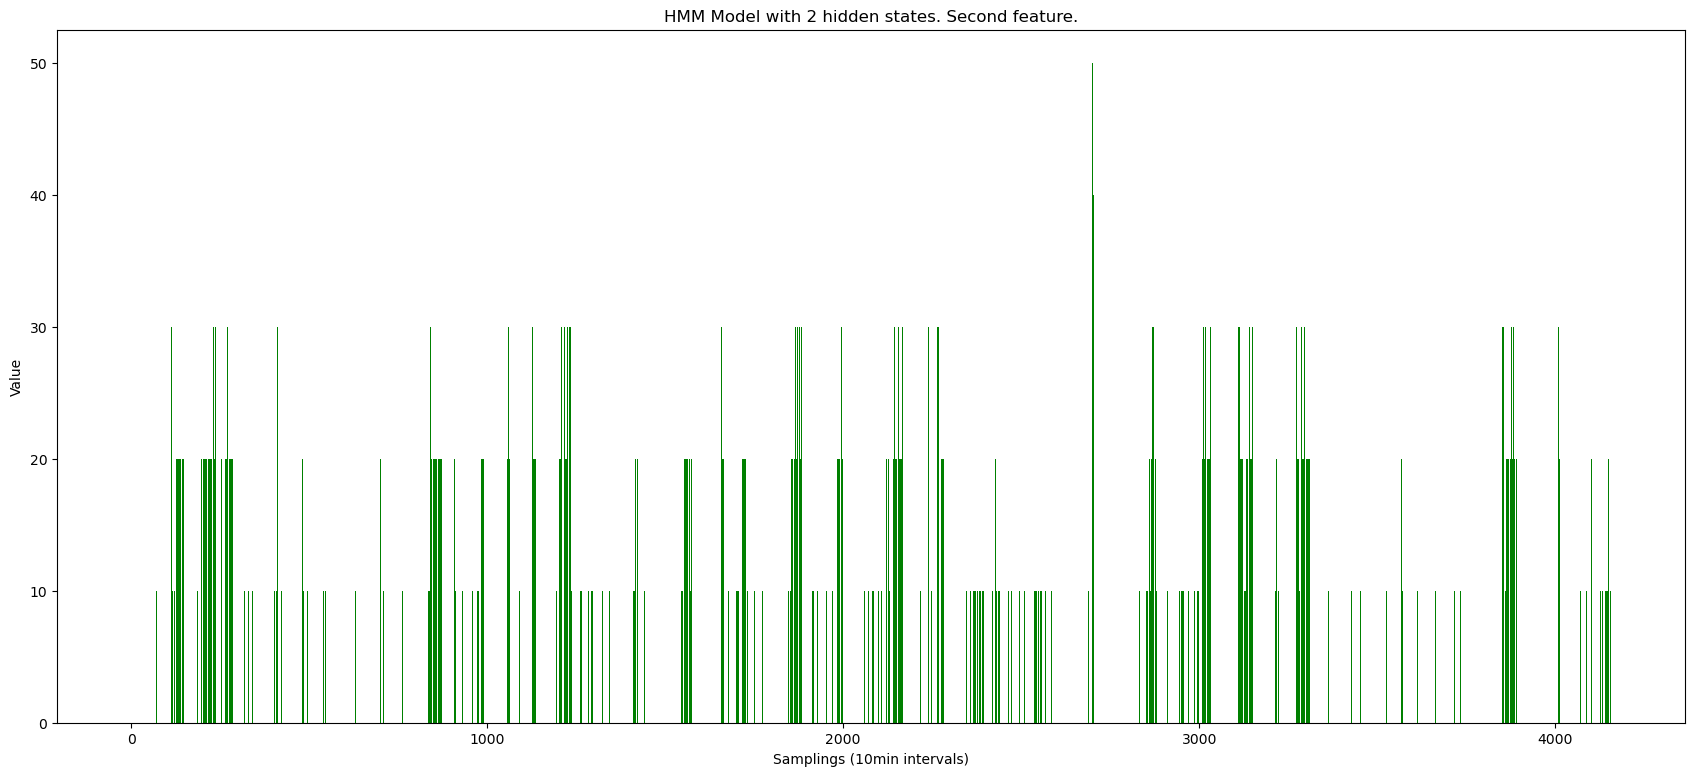

In [74]:

hidden_sequence, model = train_and_plot_double(
    visible_sequence_train=train_set_mixed,
    visible_sequence_test=test_set_mixed,
    n_components=2
)